In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm
import torch

from symbolic import symbolic
from experiment.mnist_experiment import *

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [5]:
checkpt_dir = "../runs/cfd101f80881887972cab9d4211c5c70e664b711" # working

lr = 0.01 # not working
# lr = 0.02 # working
# lr = 0.009 # working
# lr = 0.008 # working
# lr = 0.005 # working
from os import listdir
from os.path import isfile, join
# onlyfiles = listdir(mypath) /
runs = [f.replace("MNIST-", "").split("_") for f in listdir(checkpt_dir) if "MNIST-" in f]
runs[:2]

[['0.01', '25', 'True', '1000'], ['0.01', '20', 'True', '2000']]

In [71]:
exp = runs[0]
print(exp)
experiment = ConstrainedMNIST(batch_size=int(exp[3]),
                              learning_rate=float(exp[0]),
                              dataset_path="../data",
                              seed=int(exp[1]),
                              zdim=50,
                              use_git_commit_to_log=False,
                              checkpoint_dir=checkpt_dir)
train_loader, valid_loader, test_loader = experiment.get_loaders()

['0.01', '25', 'True', '1000']
[4782, 11032, 16112, 21541, 26123, 30173, 35055, 40571, 45564, 50300, 45554, 39774, 34061, 28978, 24319, 20123, 15239, 9760, 4939]
[4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782, 4782]
[2312, 4940, 6913, 9229, 11286, 13029, 15265, 17468, 19614, 21408, 19599, 16615, 14571, 12113, 10213, 8642, 6468, 4162, 2153]
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]
[209, 449, 621, 897, 1037, 1203, 1367, 1596, 1769, 2029, 1820, 1539, 1360, 1119, 954, 777, 628, 407, 219]


# Check dataset

In [72]:
# for data in test_loader:
#     model_input = experiment.get_input_data(data)
#     target = experiment.get_target_data(data)
#     (tgt1, tgt2, tgt3, tgt4), (lbl1, lbl2, lbl3, lbl4) = target
#     break

# fig, axes = plt.subplots(10, 4, figsize=(15,40))

# choices = np.random.choice(range(len(tgt1)), size=10, replace=False)
# for i, row in enumerate(axes):
#     ix = choices[i]
#     for j, (tgt, lbl) in enumerate(zip([tgt1[ix], tgt2[ix], tgt3[ix], tgt4[ix]], [lbl1[ix], lbl2[ix], lbl3[ix], lbl4[ix]])):
        
#         ax = row[j]
        
#         ax.set_title(lbl.item())
#         ax.imshow((tgt.view(28, 28).detach().numpy()*255).astype(np.uint8), cmap='gray_r')
#         ax.grid(False)
#         ax.set_axis_off()
        
# plt.show()

# Check Model Samples

In [73]:
model = experiment.load_model(use_final=True)

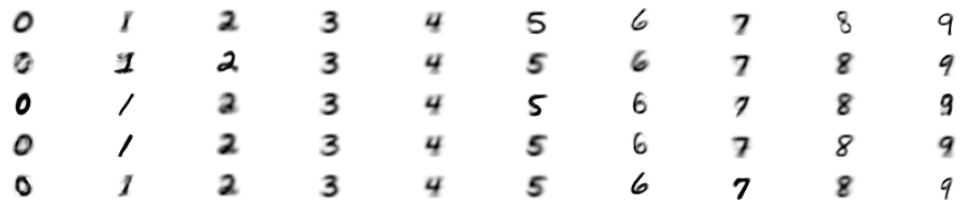

In [89]:
fig, axes = plt.subplots(5, 10, figsize=(15, 3))
model.eval()

for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        z_ = torch.randn((1, experiment.zdim))
    
        recon = model.decode_one(z_, label=j)
        ax.imshow(
            (
                torch.sigmoid(recon[0]).view(28, 28).detach().numpy() * 255
            ).astype(np.uint8),
            cmap="gray_r",
        )
        ax.grid(False)
        ax.set_axis_off()

plt.savefig("images/mnist_samples_from_prior.png", format='png', dpi=600)

fig.tight_layout()
plt.show()

# Get accuracy on test set out set of data

In [114]:
def parse_line_to_loss_and_accuracy(line):
    [loss, acc, mae, ent] = line.replace("Test  [1/100]: ", "").split("\t")
    loss = float(loss.strip().split(" ")[1])
    acc = float(acc.strip().split(" ")[1])
    mae = float(mae.strip().split(" ")[1])
    ent = float(ent.strip().split(" ")[1])
    return [loss, acc, mae, ent]

In [118]:
from os import listdir
from os.path import isfile, join

accs = []
onlyfiles = [f for f in listdir(checkpt_dir+"/logs") if isfile(join(checkpt_dir+"/logs", f))]
for file in onlyfiles:
    with open(join(checkpt_dir+"/logs", file), "r") as f:
        for i, line in enumerate(f.readlines()):
            if "Test  [1/100]" in line.strip():
                if i == 417:
#                     print(i)
                    [loss, acc, mae, ent] = parse_line_to_loss_and_accuracy(line)
                    if loss < 135:
                        accs += [acc]
# list(listdir(checkpt_dir+'/logs'))
len(accs), np.mean(accs), np.std(accs)

(5, 97.5672, 0.2617436914234994)